# Basic 3D Deep Learning Examples
Using [modelnet](https://modelnet.cs.princeton.edu/) data and some [kaolin tutorials](https://github.com/NVIDIAGameWorks/kaolin/tree/1622437ce0964844e47ede8a5fbaf9c83bc8efe7/examples)

    

In [2]:
import os
import random
import pickle
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn

import kaolin as kal
from kaolin import ClassificationEngine
from kaolin.datasets import ModelNet, ModelNetVoxels
from kaolin.models.PointNet import PointNetClassifier as PointNet
import kaolin.transforms as tfs

# from models import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Look into ModelNet Dataset

In [3]:
modelnet_path = './data/ModelNet10'
categories = ['chair', 'sofa']
device = 'cuda'

#### Classes in dataset

In [4]:
[p for p in os.listdir(modelnet_path) if os.path.isdir(os.path.join(modelnet_path, p))]

['cache',
 'dresser',
 'desk',
 'night_stand',
 'bathtub',
 'chair',
 'sofa',
 'monitor',
 'table',
 'toilet',
 'bed']

In [5]:
dataset = ModelNetVoxels(modelnet_path, categories=categories,
                   split='train', device=device)
print(len(dataset))
print(dataset[0].keys())
print(dataset[0]['data']['32'].size())
print(dataset[0]['attributes']['category'])

converting to voxels to resolution 32: 100%|██████████| 1569/1569 [00:00<00:00, 30106.93it/s]

1569
dict_keys(['data', 'attributes'])
torch.Size([32, 32, 32])
chair


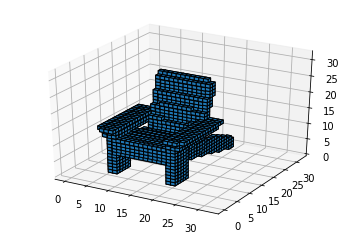

In [6]:
train_loader = DataLoader(dataset, batch_size=32)
batch = next(iter(train_loader))
# batch['attributes']['category']
voxels = batch['data']['32'][0, :, :, :]

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(voxels, edgecolor='k')
plt.show()

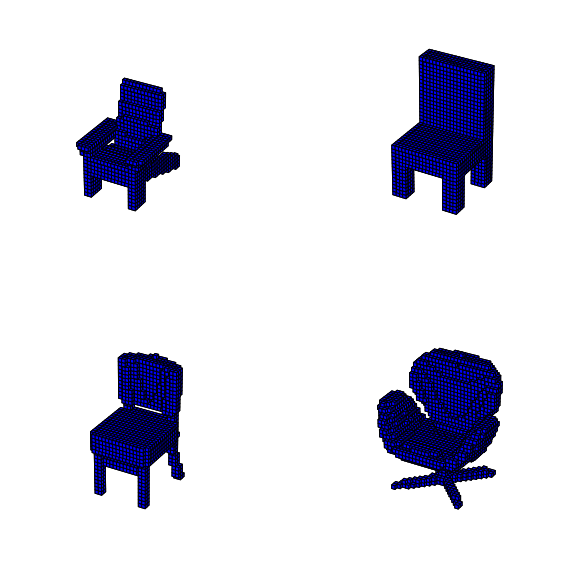

In [7]:
def plot_voxels(batch):
    nrows, ncols = 2, 2
    voxels = batch['data']['32'][:nrows*ncols, :, :, :]
    labels = batch['attributes']['category'][:nrows*ncols:]
    fig = plt.figure(figsize=(10, 10))
    for idx in range(voxels.size(0)):
        label = labels[idx]
        ax = fig.add_subplot(nrows, ncols, idx + 1, projection='3d')
        ax.voxels(voxels[idx, :, :, :], facecolors='blue', edgecolor='k')
        ax.axis('off')
#         ax.set_title(labels[idx])
    fig.savefig('./plots/chair_.pdf')
plot_voxels(batch)

## Tutorial classifier on pointcloud
https://github.com/NVIDIAGameWorks/kaolin/blob/master/examples/Classification/point_cloud_classification.ipynb

In [6]:
num_points = 1024

transform = tfs.Compose([
    tfs.TriangleMeshToPointCloud(num_samples=num_points),
    tfs.NormalizePointCloud()
])
train_loader = DataLoader(ModelNet(modelnet_path, categories=categories,
                                   split='train', transform=transform, device=device),
                          batch_size=88, shuffle=True)

val_loader = DataLoader(ModelNet(modelnet_path, categories=categories,
                                 split='test',transform=transform, device=device),
                        batch_size=88)

In [7]:
x, y  = next(iter(train_loader))
print(x.size(), y.size())

torch.Size([88, 1024, 3]) torch.Size([88])


In [8]:
engineparams = {'epochs': 3, 
               'validate-every': 10,
               'print-every': 10}

engine = ClassificationEngine(PointNet(num_classes=len(categories)),
                              train_loader, val_loader, device=device, 
                              engineparams=engineparams)
engine.fit()

Epoch: 0, Train loss: 0.7536557912826538, Train accuracy: 0.3636363744735718
Epoch: 0, Train loss: 0.4254578985273838, Train accuracy: 0.6818181872367859
Epoch: 0, Train loss: 0.3149096295237541, Train accuracy: 0.7803030411402384
Epoch: 0, Train loss: 0.2443372281268239, Train accuracy: 0.8352272808551788
Epoch: 0, Train loss: 0.20071572288870812, Train accuracy: 0.8681818246841431
Epoch: 0, Train loss: 0.17015821548799673, Train accuracy: 0.8901515205701193
Epoch: 0, Train loss: 0.14942385548991816, Train accuracy: 0.9058441604886737
Epoch: 0, Train loss: 0.1325000214856118, Train accuracy: 0.9176136404275894
Epoch: 0, Train loss: 0.1269271264059676, Train accuracy: 0.9217171801461114
Epoch: 0, Train loss: 0.11527051012963056, Train accuracy: 0.9295454621315002
Epoch: 0, Train loss: 0.10593055857514794, Train accuracy: 0.9359504201195457
Epoch: 0, Train loss: 0.09790091752074659, Train accuracy: 0.9412878851095835
Epoch: 0, Train loss: 0.09117698927338307, Train accuracy: 0.945804201

In [13]:
def visualize_batch(pointclouds, pred_labels, labels, categories):
    batch_size = len(pointclouds)
    fig = plt.figure(figsize=(8, batch_size / 2))
    ncols = 5
    nrows = max(1, batch_size // 5)
    for idx, pc in enumerate(pointclouds):
        label = categories[labels[idx].item()]
        pred = categories[pred_labels[idx]]
        colour = 'g' if label == pred else 'r'
        pc = pc.cpu().numpy()
        ax = fig.add_subplot(nrows, ncols, idx + 1, projection='3d')
        ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c=colour, s=2)
        ax.axis('off')
        ax.set_title('GT: {0}\nPred: {1}'.format(label, pred))
    plt.show()

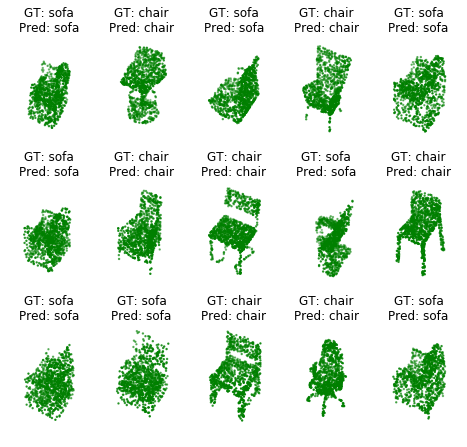

In [14]:
test_loader = DataLoader(ModelNet(modelnet_path, categories=categories,
                                 split='test',transform=transform, device=device),
                        shuffle=True, batch_size=15)

test_batch, labels = next(iter(test_loader))
preds = engine.model(test_batch)
pred_labels = torch.max(preds, axis=1)[1]

visualize_batch(test_batch, pred_labels, labels, categories)

## VAE on Voxels

GAN example https://arxiv.org/pdf/1610.07584.pdf

In [4]:
class VAE(nn.Module):
    def __init__(self, latent_size=8):
        super(VAE, self).__init__()
        self.latent_size = latent_size
        self.enc_conv1 = nn.Conv3d(1, 16, 3, stride = 1, padding=1)
        self.enc_bn1 = nn.BatchNorm3d(16)
        self.enc_conv2 = nn.Conv3d(16, 32, 3, stride = 2, padding=1)
        self.enc_bn2 = nn.BatchNorm3d(32)
        self.enc_conv3 = nn.Conv3d(32, 32, 3, stride = 2, padding=1)
        self.enc_bn3 = nn.BatchNorm3d(32)
        self.enc_conv4 = nn.Conv3d(32, 8, 3, stride = 2, padding=1)
        self.enc_bn4 = nn.BatchNorm3d(8)
        
        self.enc_fc = nn.Linear(512, self.latent_size)
        self.dec_fc = nn.Linear(self.latent_size, 512)
        
        self.dec_conv1 = nn.ConvTranspose3d(8, 32, 3, stride = 2,  padding=0)
        self.dec_bn1 = nn.BatchNorm3d(32)
        self.dec_conv2 = nn.ConvTranspose3d(32, 32, 3, stride = 2,  padding=1)
        self.dec_bn2 = nn.BatchNorm3d(32)
        self.dec_conv3 = nn.ConvTranspose3d(32, 16, 3, stride = 2,  padding=1)
        self.dec_bn3 = nn.BatchNorm3d(16)
        self.dec_conv4 = nn.ConvTranspose3d(16, 1, 3, stride = 1, padding=1)
        
    def reparameterize_1std(self, mu):
        return mu + torch.randn_like(mu)
        
    def forward(self, x):
        x = F.relu(self.enc_bn1(self.enc_conv1(x)))
#         print('e1', x.size())
        x = F.relu(self.enc_bn2(self.enc_conv2(x)))
#         print('e2', x.size())
        x = F.relu(self.enc_bn3(self.enc_conv3(x)))
        x = F.relu(self.enc_bn4(self.enc_conv4(x)))
#         print('e4', x.size())

        x = x.view(-1, 8*4*4*4)
#         print(x.size())
        mu = self.enc_fc(x)
#         print(mu.size())

        x = self.reparameterize_1std(mu)
        x = self.dec_fc(x)
        x = x.view(-1, 8, 4, 4, 4)
        
        x = F.relu(self.dec_bn1(self.dec_conv1(x)))
#         print('d1', x.size())
        x = F.relu(self.dec_bn2(self.dec_conv2(x)))
#         print('d2', x.size())
        x = F.relu(self.dec_bn3(self.dec_conv3(x)))
        x = self.dec_conv4(x)
#         print('d4', x.size())
        return torch.sigmoid(x)[:,0, :32,:32,:32], mu

In [178]:
8*4*4*4

512

In [27]:
def loss_function(recon_x, x, mu):
    BCE = F.binary_cross_entropy(recon_x.squeeze(), x.squeeze(), reduction='sum')
    KLD = -0.5 * torch.sum(1 + 0 - mu.pow(2) - 1)#logvar.exp())
    return BCE + KLD


def train(epoch, print_freq=5):
    model.train()
    train_loss = 0
    for batch_idx, batch in enumerate(train_loader):
        data = batch['data']['32'].to(device).unsqueeze(1)
        optimizer.zero_grad()
        recon_batch, mu = model(data)
        loss = loss_function(recon_batch, data, mu)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if epoch % print_freq == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(
              epoch, train_loss / len(train_loader.dataset)))


def val(epoch, print_freq=5):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
                data = batch['data']['32'].to(device).unsqueeze(1)
                recon_batch, mu = model(data)
                val_loss += loss_function(recon_batch, data, mu).item()
        val_loss /= len(val_loader.dataset)
    if epoch % print_freq == 0:
        print('====> Val set loss: {:.4f}'.format(val_loss))

In [11]:
def plot_recon_voxels(batch, model, nsamples=4, voxel_threshold=.5):
    x = batch['data']['32'].to(device)[:nsamples, :, :, :].unsqueeze(1)
    recon_x, mu = model(x)
    recon_x = recon_x > voxel_threshold
    x, recon_x = x.squeeze(), recon_x.squeeze()
    labels = batch['attributes']['category'][:nsamples]
    
    nrows, ncols = nsamples, 2
    fig = plt.figure(figsize=(8, 3*nsamples))
    for idx in range(0, x.size(0), 1):
        label = labels[idx]
        ax = fig.add_subplot(nrows, ncols, 2*idx + 1, projection='3d')
        ax.voxels(x[idx, :, :, :], facecolors='blue', edgecolor='k')
        ax.axis('off')
        ax.set_title(labels[idx])
        
        ax = fig.add_subplot(nrows, ncols, 2*idx + 2, projection='3d')
        ax.voxels(recon_x[idx, :, :, :], facecolors='blue', edgecolor='k')
        ax.axis('off')

In [163]:
train_loader = DataLoader(ModelNetVoxels(modelnet_path, categories=categories, resolutions=[32],
                                         split='train', device=device), batch_size=256)
val_loader = DataLoader(ModelNetVoxels(modelnet_path, categories=categories, resolutions=[32],
                                         split='test', device=device), batch_size=256)

converting to voxels to resolution 32: 100%|██████████| 200/200 [00:00<00:00, 73481.15it/s]


====> Epoch: 5 Average loss: 6287.6144
====> Val set loss: 7410.5262
====> Epoch: 10 Average loss: 5112.6505
====> Val set loss: 7501.4288


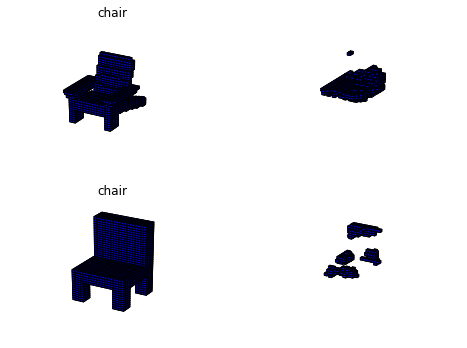

In [164]:
model = VAE().to(device)

optimizer = optim.Adam(model.parameters(), lr=3e-3)
epochs = 10

for epoch in range(1, epochs + 1):
    train(epoch)
    val(epoch)
batch = next(iter(train_loader))
plot_recon_voxels(batch, model, nsamples=2, voxel_threshold=.3)

====> Epoch: 15 Average loss: 4598.3374
====> Val set loss: 5062.9344


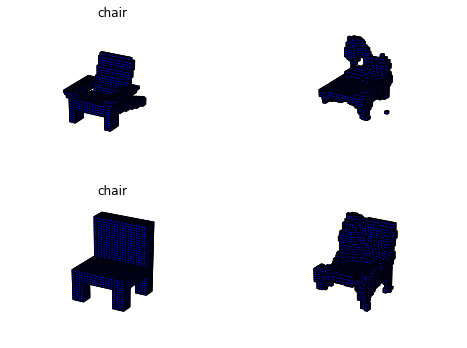

In [165]:
for epoch in range(11, 20):
    train(epoch)
    val(epoch)
batch = next(iter(train_loader))
plot_recon_voxels(batch, model, nsamples=2, voxel_threshold=.3)

====> Epoch: 25 Average loss: 4166.2800
====> Val set loss: 4547.2431
====> Epoch: 30 Average loss: 4203.9751
====> Val set loss: 5806.3506
====> Epoch: 35 Average loss: 3762.6085
====> Val set loss: 4288.0306
====> Epoch: 40 Average loss: 3770.7346
====> Val set loss: 4087.3184
====> Epoch: 45 Average loss: 3692.0977
====> Val set loss: 4000.6931


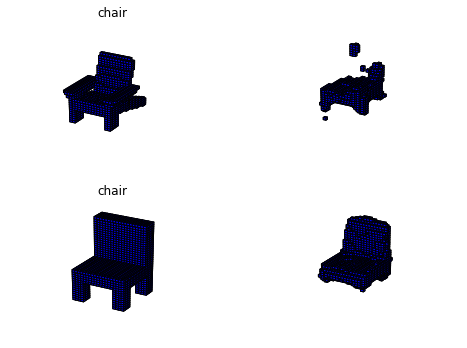

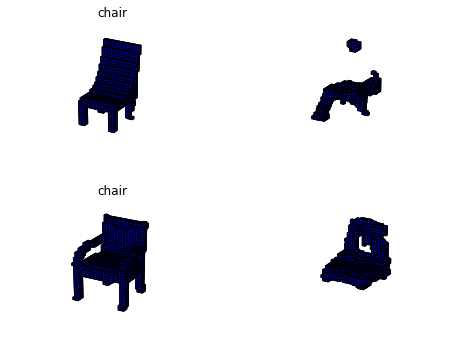

In [166]:
for epoch in range(21, 50):
    train(epoch)
    val(epoch)
    
batch = next(iter(train_loader))
plot_recon_voxels(batch, model, nsamples=2, voxel_threshold=.3)

batch = next(iter(val_loader))
plot_recon_voxels(batch, model, nsamples=2, voxel_threshold=.3)

====> Epoch: 55 Average loss: 3568.9608
====> Val set loss: 4011.8016
====> Epoch: 60 Average loss: 3428.3247
====> Val set loss: 3872.6431
====> Epoch: 65 Average loss: 3444.4094
====> Val set loss: 3879.1922
====> Epoch: 70 Average loss: 3556.1329
====> Val set loss: 3913.0156
====> Epoch: 75 Average loss: 3850.6263
====> Val set loss: 4395.0228
====> Epoch: 80 Average loss: 3338.5992
====> Val set loss: 3969.5134
====> Epoch: 85 Average loss: 3307.3948
====> Val set loss: 3740.1816
====> Epoch: 90 Average loss: 3339.6954
====> Val set loss: 3934.6866
====> Epoch: 95 Average loss: 3216.2741
====> Val set loss: 3834.9444


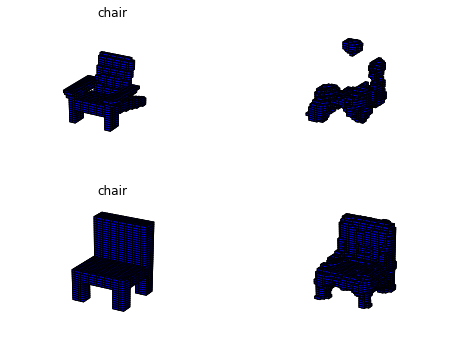

In [167]:
for epoch in range(51, 100):
    train(epoch)
    val(epoch)
    
batch = next(iter(train_loader))
plot_recon_voxels(batch, model, nsamples=2, voxel_threshold=.3)

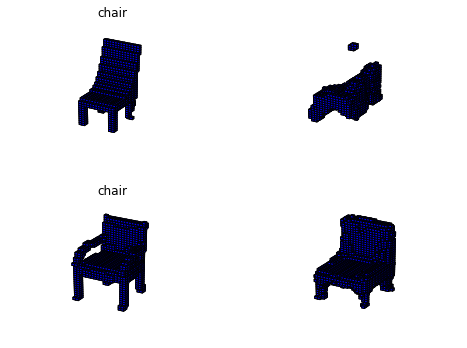

In [168]:
batch = next(iter(val_loader))
plot_recon_voxels(batch, model, nsamples=2, voxel_threshold=.3)

====> Epoch: 105 Average loss: 3483.9107
====> Val set loss: 3932.0453
====> Epoch: 110 Average loss: 3376.9864
====> Val set loss: 3732.5797
====> Epoch: 115 Average loss: 3218.4439
====> Val set loss: 3636.9256
====> Epoch: 120 Average loss: 3097.6153
====> Val set loss: 3558.2038
====> Epoch: 125 Average loss: 3112.1095
====> Val set loss: 3735.5400
====> Epoch: 130 Average loss: 3172.9031
====> Val set loss: 3717.8962
====> Epoch: 135 Average loss: 3171.6465
====> Val set loss: 3676.1322
====> Epoch: 140 Average loss: 3073.1090
====> Val set loss: 3613.3550
====> Epoch: 145 Average loss: 3149.5981
====> Val set loss: 3660.6169
====> Epoch: 150 Average loss: 3226.4676
====> Val set loss: 4709.7978
====> Epoch: 155 Average loss: 3193.2282
====> Val set loss: 3715.0859
====> Epoch: 160 Average loss: 3038.1756
====> Val set loss: 3577.7153
====> Epoch: 165 Average loss: 2996.9468
====> Val set loss: 3582.8284
====> Epoch: 170 Average loss: 3021.1013
====> Val set loss: 3582.4466
====> 

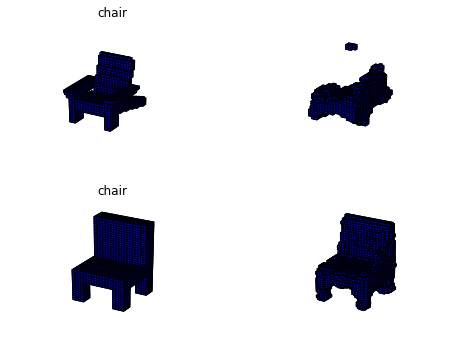

In [169]:
for epoch in range(101, 200):
    train(epoch)
    val(epoch)
    
batch = next(iter(train_loader))
plot_recon_voxels(batch, model, nsamples=2, voxel_threshold=.3)

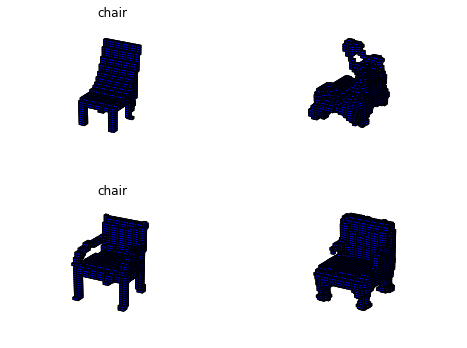

In [170]:
batch = next(iter(val_loader))
plot_recon_voxels(batch, model, nsamples=2, voxel_threshold=.3)

## Single class, overfit

In [9]:
modelnet_path = './data/ModelNet10'
categories = ['chair']
device = 'cuda:0'

train_loader = DataLoader(ModelNetVoxels(modelnet_path, categories=categories, resolutions=[32],
                                         split='train', device=device), batch_size=256)
val_loader = DataLoader(ModelNetVoxels(modelnet_path, categories=categories, resolutions=[32],
                                         split='test', device=device), batch_size=256)

converting to voxels to resolution 32: 100%|██████████| 100/100 [00:00<00:00, 64241.14it/s]


In [28]:
from torch.optim.lr_scheduler import MultiStepLR, StepLR


model = VAE(latent_size=32).to(device)

epochs = 400
optimizer = optim.Adam(model.parameters(), lr=3e-3)
scheduler = MultiStepLR(optimizer, milestones=[100, 200, 300], gamma=0.2)


for epoch in range(1, epochs + 1):
    train(epoch, print_freq=5)
    val(epoch, print_freq=5)
    scheduler.step()

KeyboardInterrupt: 

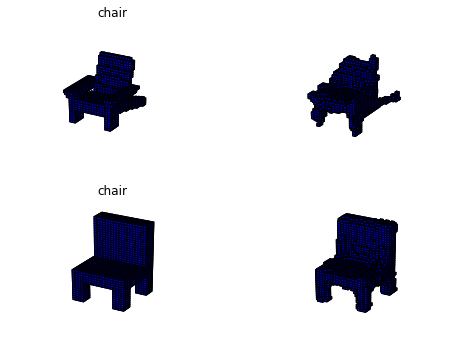

In [12]:
batch = next(iter(train_loader))
plot_recon_voxels(batch, model, nsamples=2, voxel_threshold=.3)

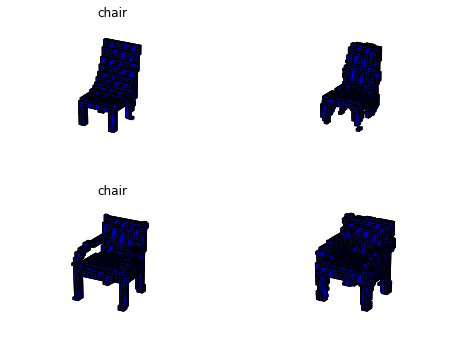

In [13]:
batch = next(iter(val_loader))
plot_recon_voxels(batch, model, nsamples=2, voxel_threshold=.3)

## Sanity check overfit
- One batch

In [33]:
modelnet_path = './data/ModelNet10'
categories = ['chair']
device = 'cuda:0'

trainset = ModelNetVoxels(modelnet_path, categories=categories, resolutions=[32],
                                         split='train', device=device)
valset = ModelNetVoxels(modelnet_path, categories=categories, resolutions=[32],
                                         split='test', device=device)
trainset.names = trainset.names[:4]
valset.names = valset.names[:256]

print('len(trainset)', len(trainset))
train_loader = DataLoader(trainset, batch_size=2)
val_loader = DataLoader(valset, batch_size=256)

converting to voxels to resolution 32: 100%|██████████| 100/100 [00:00<00:00, 57283.58it/s]

len(trainset) 4


====> Epoch: 50 Average loss: 2247.2969
====> Val set loss: 10171.3806
====> Epoch: 100 Average loss: 695.3338
====> Val set loss: 22047.9075
====> Epoch: 150 Average loss: 364.3171
====> Val set loss: 27777.5750
====> Epoch: 200 Average loss: 222.2191
====> Val set loss: 31623.0775
====> Epoch: 250 Average loss: 138.4930
====> Val set loss: 33505.5750
====> Epoch: 300 Average loss: 103.5517
====> Val set loss: 35307.5000
====> Epoch: 350 Average loss: 76.8442
====> Val set loss: 35247.8625
====> Epoch: 400 Average loss: 64.5502
====> Val set loss: 36935.6000
====> Epoch: 450 Average loss: 73.8086
====> Val set loss: 37907.7175
====> Epoch: 500 Average loss: 85.8741
====> Val set loss: 34881.7200
====> Epoch: 550 Average loss: 58.8456
====> Val set loss: 36267.8575
====> Epoch: 600 Average loss: 51.2673
====> Val set loss: 37090.8600
====> Epoch: 650 Average loss: 60.7128
====> Val set loss: 36873.0725
====> Epoch: 700 Average loss: 50.3680
====> Val set loss: 37805.3975
====> Epoch: 7

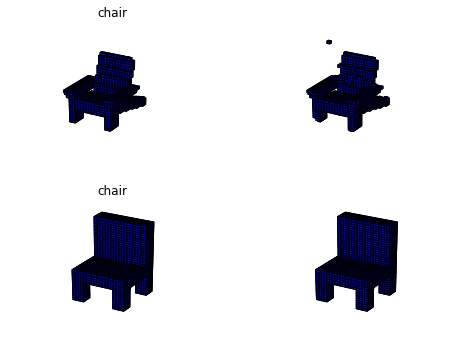

In [34]:
from torch.optim.lr_scheduler import MultiStepLR, StepLR
model = VAE().to(device)

optimizer = optim.Adam(model.parameters(), lr=3e-3)
scheduler = StepLR(optimizer, step_size=int(epochs/3), gamma=0.2)
epochs = 1000

for epoch in range(1, epochs + 1):
    train(epoch, print_freq=50)
    val(epoch, print_freq=50)
    scheduler.step()
    
batch = next(iter(train_loader))
plot_recon_voxels(batch, model, nsamples=2, voxel_threshold=.3)